# Notebook Description
Run models on the test set and compare them.

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt


# Set options and load file
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext google.colab.data_table
from google.colab import data_table
from google.colab import drive

drive.mount('/content/drive')
os.chdir("YOUR FOLDER HERE")
raw_data_folder = './data/raw/'
interim_data_folder = './data/interim/'
processed_data_folder = './data/processed/'
models_folder = './models/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot, LSTM, Bidirectional, Reshape,Flatten
from keras.layers.core import Dense
from keras import backend
from keras import backend as K

from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D

!pip install keras_nlp
from keras_nlp.layers import PositionEmbedding


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1d-CNN

In [ ]:
# Load Data
# -------------
alphabet = 'eainlrsotdychmbugkjpfvzwxq.ó'
print('Alphabet:')
print(alphabet)

# Load Data
# -------------
alphabet = 'eainlrsotdychmbugkjpfvzwxq.ó'
print('Alphabet:')
print(alphabet)

# Original dfs
test_df = pd.read_csv(interim_data_folder + 'test_df_mixed_shuffled.csv', index_col=0)

# tokenized dfs
test_data_names = np.loadtxt(processed_data_folder + 'test_mixed_data_names.txt', dtype = int)
test_data_nicknames = np.loadtxt(processed_data_folder + 'test_mixed_data_nicknames.txt', dtype = int)

# targets
test_targets = np.loadtxt(processed_data_folder + 'test_mixed_targets.txt', dtype = int)


Alphabet:
eainlrsotdychmbugkjpfvzwxq.ó
Alphabet:
eainlrsotdychmbugkjpfvzwxq.ó


32/32 [==============================] - 5s 16ms/step
0.7961137388491324


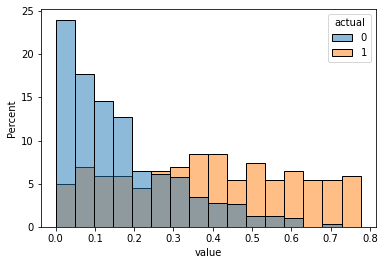

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_different_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_test = pd.DataFrame(model.predict([test_data_names, test_data_nicknames]), columns = ['value'])
preds_test['actual'] = test_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_test['actual'].values, 
                                         preds_test['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_test, stat="percent", common_norm=False)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
preds_test['predicted'] = (preds_test['value']>0.25).astype(int)
print("Accuracy:", accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Balanced Accuracy:", balanced_accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Percision:", precision_score(preds_test['actual'], preds_test['predicted']))
print("Recall:", recall_score(preds_test['actual'], preds_test['predicted']))


Accuracy: 0.7544554455445545
Balanced Accuracy: 0.7370049504950495
Percision: 0.4307228915662651
Recall: 0.7079207920792079


# 2d-CNN

In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))



# load data
test_df_shuffled = pd.read_csv(interim_data_folder + 'test_df_shuffled.csv', index_col=0)
y_test=test_df_shuffled['y'].values
y_test = tf.cast(y_test, tf.float32)

test_names_mat = np.load(processed_data_folder + 'test_names_mat.npy',allow_pickle='True')
test_nicknames_mat = np.load(processed_data_folder + 'test_nicknames_mat.npy',allow_pickle='True')

test_names_mat = tf.expand_dims(test_names_mat, axis = -1)
test_nicknames_mat = tf.expand_dims(test_nicknames_mat, axis = -1)

print(test_names_mat.shape)
print(test_nicknames_mat.shape)



(1010, 128, 80, 1)
(1010, 128, 80, 1)


32/32 [==============================] - 1s 20ms/step
0.8291803499656897


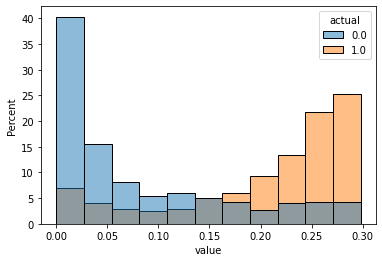

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_2dCNN_15k.hdf5', custom_objects={'contrastive_loss': loss})

preds_test = pd.DataFrame(model.predict([test_names_mat, test_nicknames_mat]), columns = ['value'])
preds_test['actual'] = y_test

fpr, tpr, thresholds = metrics.roc_curve(preds_test['actual'].values, 
                                         preds_test['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_test, stat="percent", common_norm=False)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
preds_test['predicted'] = (preds_test['value']>0.15).astype(int)
print("Accuracy:", accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Balanced Accuracy:", balanced_accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Percision:", precision_score(preds_test['actual'], preds_test['predicted']))
print("Recall:", recall_score(preds_test['actual'], preds_test['predicted']))


Accuracy: 0.7891089108910891
Balanced Accuracy: 0.7939356435643565
Percision: 0.4835820895522388
Recall: 0.801980198019802


# String based

In [ ]:
!pip install jaro-winkler
!pip install editdistance
import jaro
import editdistance

# Load
test_df = pd.read_csv(interim_data_folder + 'test_df_mixed_shuffled.csv', index_col=0)
y_test = test_df['y']


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Jaro

0.9260458533477112


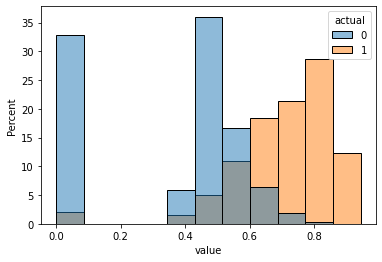

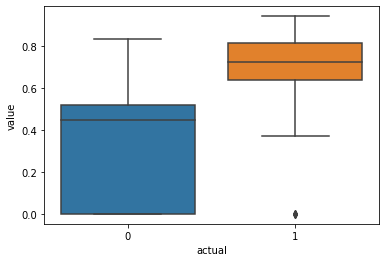

In [ ]:
preds_test = pd.DataFrame([jaro.jaro_metric(test_df['name'][j],test_df['nickname'][j]) for j in range(len(test_df))], columns = ['value'])
preds_test['actual'] = y_test

fpr, tpr, thresholds = metrics.roc_curve(preds_test['actual'].values, 
                                         preds_test['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_test, stat="percent", common_norm=False)
plt.show()
sns.boxplot(data = preds_test, y='value', x='actual')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
preds_test['predicted'] = (preds_test['value']>0.55).astype(int)
print("Accuracy:", accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Balanced Accuracy:", balanced_accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Percision:", precision_score(preds_test['actual'], preds_test['predicted']))
print("Recall:", recall_score(preds_test['actual'], preds_test['predicted']))


Accuracy: 0.8306930693069307
Balanced Accuracy: 0.844059405940594
Percision: 0.54858934169279
Recall: 0.8663366336633663


## Jaro-Winkler

0.9271578766787569


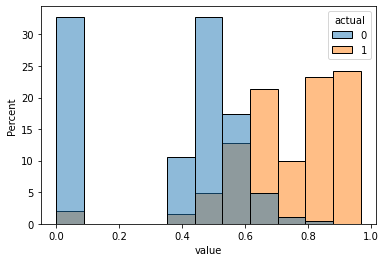

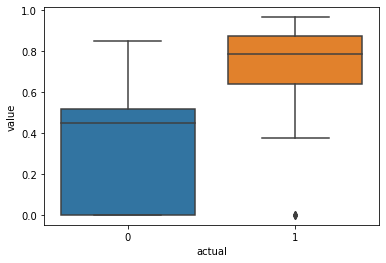

In [ ]:
preds_test = pd.DataFrame([jaro.jaro_winkler_metric(test_df['name'][j],test_df['nickname'][j]) for j in range(len(test_df))], columns = ['value'])
preds_test['actual'] = y_test

fpr, tpr, thresholds = metrics.roc_curve(preds_test['actual'].values, 
                                         preds_test['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_test, stat="percent", common_norm=False)
plt.show()
sns.boxplot(data = preds_test, y='value', x='actual')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
preds_test['predicted'] = (preds_test['value']>0.55).astype(int)
print("Accuracy:", accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Balanced Accuracy:", balanced_accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Percision:", precision_score(preds_test['actual'], preds_test['predicted']))
print("Recall:", recall_score(preds_test['actual'], preds_test['predicted']))


Accuracy: 0.8306930693069307
Balanced Accuracy: 0.844059405940594
Percision: 0.54858934169279
Recall: 0.8663366336633663


## Levinstein

0.8551398147240467


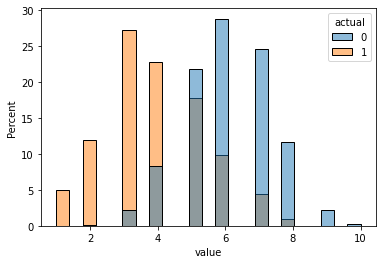

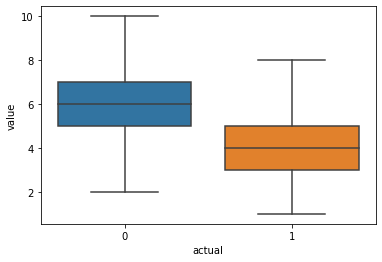

In [ ]:
preds_test = pd.DataFrame([editdistance.eval(test_df['name'][j],test_df['nickname'][j]) for j in range(len(test_df))], columns = ['value'])
preds_test['actual'] = y_test

fpr, tpr, thresholds = metrics.roc_curve(preds_test['actual'].values, 
                                         preds_test['value'].values)
print(max(metrics.auc(fpr, tpr), 1-metrics.auc(fpr, tpr)))

sns.histplot(x = 'value', hue = 'actual', data = preds_test, stat="percent", common_norm=False)
plt.show()

sns.boxplot(data = preds_test, y='value', x='actual')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
preds_test['predicted'] = (preds_test['value']<5).astype(int)
print("Accuracy:", accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Balanced Accuracy:", balanced_accuracy_score(preds_test['actual'], preds_test['predicted']))
print("Percision:", precision_score(preds_test['actual'], preds_test['predicted']))
print("Recall:", recall_score(preds_test['actual'], preds_test['predicted']))


Accuracy: 0.8485148514851485
Balanced Accuracy: 0.780940594059406
Percision: 0.6108597285067874
Recall: 0.6683168316831684
